In [91]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [92]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [93]:
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

In [94]:
train_data = datasets.FashionMNIST(
    root='data',
    train= True,
    download = True,
    transform = ToTensor(),
    target_transform =None
)
test_data = datasets.FashionMNIST(
    root='data',
    train= False,
    download = True,
    transform = ToTensor(),
    target_transform =None
)

In [95]:
class_names = train_data.classes

In [96]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data,batch_size=BATCH_SIZE,shuffle=True)

test_dataloader = DataLoader(dataset=test_data,batch_size=BATCH_SIZE,shuffle=False)

train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1c705fa8dd0>,
 <torch.utils.data.dataloader.DataLoader at 0x1c776f27250>)

In [197]:
class FashionMnist(nn.Module):
    def __init__(self,input_shape,output_shape,hidden_units):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.MaxPool2d(kernel_size=2),
        )
        self.flatten_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )
    def forward(self,x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.flatten_layer(x)
        return x

In [198]:
model1 = FashionMnist(input_shape=1,hidden_units=10,output_shape=len(class_names)).to(device)

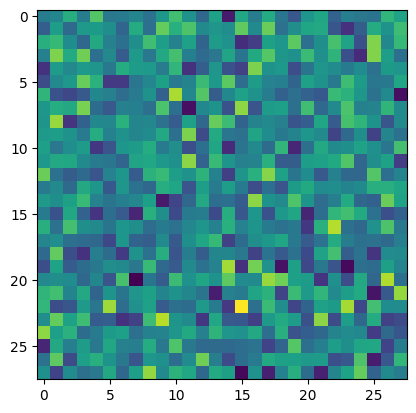

In [199]:
x_dummy = torch.randn(32,3,28,28)
test_image = x_dummy[0]
plt.subplot(1,1,1)
plt.imshow(test_image[0])
plt.show()

In [200]:
test_image.shape

torch.Size([3, 28, 28])

In [201]:
conv_layer = nn.Conv2d(in_channels=3,
                      out_channels=10,
                      kernel_size=3,
                      stride=1,
                      padding=1)
output = conv_layer(test_image)
output.shape

torch.Size([10, 28, 28])

In [202]:
conv_layer1 = nn.MaxPool2d(kernel_size=3)
output = conv_layer1(test_image)
print(test_image.shape)
output.shape

torch.Size([3, 28, 28])


torch.Size([3, 9, 9])

In [ ]:
from torchinfo import summary
summary(model1,input_size=[32,1,28,28])

In [203]:
loss_fn = nn.CrossEntropyLoss()
lr = 0.1
optimizer = torch.optim.SGD(params= model1.parameters(),lr=lr)

In [204]:
def train_step(model,train_dataloader,loss_fn,optimizer):
    train_loss = 0
    model.train()
    for batch,(X,y) in enumerate(train_dataloader):
        X,y = X.to(device),y.to(device)
        y_logits = model(X)
        loss = loss_fn(y_logits,y)
        train_loss+=loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(train_dataloader)
    print(f"Train loss: {train_loss}")

In [205]:
from tqdm.auto import tqdm

def test_step(model,test_dataloader,loss_fn):
    test_loss = 0
    model.eval()
    with torch.inference_mode():
        for X,y in test_dataloader:
            X,y = X.to(device),y.to(device)
            test_pred = model(X)
            loss = loss_fn(test_pred,y)
            test_loss += loss
        test_loss/=len(test_dataloader)
    print(f"Test loss: {test_loss}")

In [ ]:
epochs = 1
for epoch in tqdm(range(epochs)):
    print(f"Epoch : {epoch}")
    train_step(model1,train_dataloader,loss_fn,optimizer)
    test_step(model1,test_dataloader,loss_fn)

In [207]:
def eval_model(model: torch.nn.Module,data_loader:torch.utils.data.DataLoader,loss_fn: torch.nn.Module):
    loss = 0
    model.eval()
    with torch.inference_mode():
        for X,y in data_loader:
            X,y = X.to(device),y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred,y)
        loss /= len(data_loader)
        return ({"model_name":model.__class__.__name__,"model_loss ":loss})

In [208]:
model1_results = eval_model(model1,test_dataloader,loss_fn)
print(model1_results)

{'model_name': 'FashionMnist', 'model_loss ': tensor(0.3206, device='cuda:0')}


In [210]:
#Making and evaluating predictions
def make_predictions(model,data,device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = sample.to(device)
            pred_logit = model(sample.unsqueeze(dim=1))
            pred_prob = torch.softmax(pred_logit.squeeze(),dim=0)
            pred_probs.append(pred_prob.cpu())
        return torch.stack(pred_probs)

In [211]:
import random
# random.seed(42)
test_samples = []
test_labels = []
for sample,label in random.sample(list(test_data),k=9):
    test_samples.append(sample)
    test_labels.append(label)
test_samples[0].shape

torch.Size([1, 28, 28])

In [212]:
pred_probs = make_predictions(model=model1,data=test_samples,device=device)
pred_classes = pred_probs.argmax(dim=1)
print(pred_classes)
print(test_labels)

tensor([0, 6, 4, 1, 6, 2, 1, 0, 7])
[0, 6, 2, 1, 6, 2, 1, 0, 7]


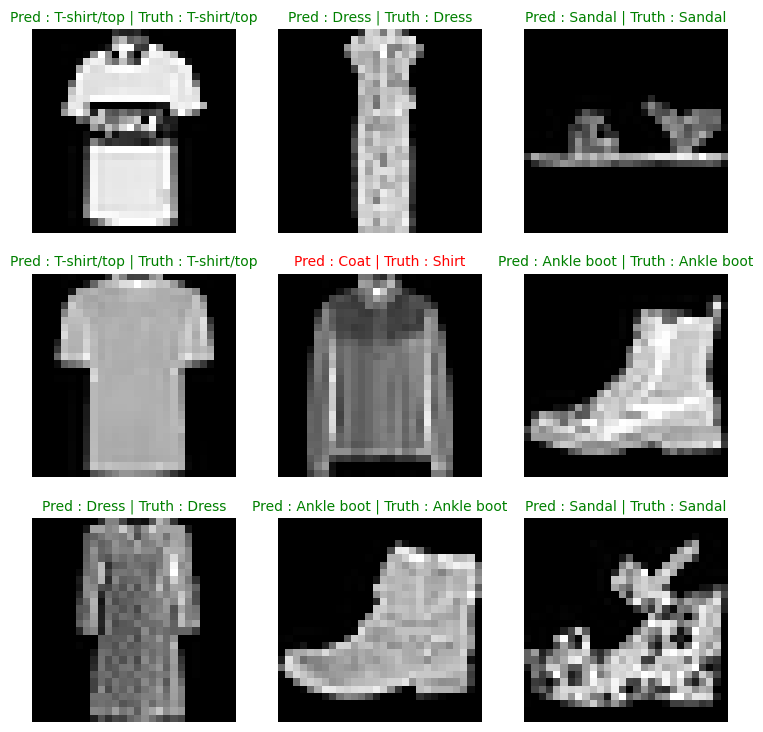

In [220]:
import random
# random.seed(42)
test_samples = []
test_labels = []
for sample,label in random.sample(list(test_data),k=9):
    test_samples.append(sample)
    test_labels.append(label)

pred_probs = make_predictions(model=model1,data=test_samples,device=device)
pred_classes = pred_probs.argmax(dim=1)

plt.figure(figsize=(9,9))
nrows = 3
ncols = 3
for i,sample in enumerate(test_samples):
    plt.subplot(nrows,ncols,i+1)
    plt.imshow(sample.squeeze(),cmap='gray')
    pred_label = class_names[pred_classes[i]]
    truth_label = class_names[test_labels[i]]
    title_text = f"Pred : {pred_label} | Truth : {truth_label}"
    if pred_label == truth_label:
        plt.title(title_text,fontsize=10,c='g')
    else:
        plt.title(title_text,fontsize=10,c='r')
    plt.axis(False)

In [214]:
from tqdm.auto import tqdm
y_preds = []
model1.eval()
with torch.inference_mode():
    for X,y in tqdm(test_dataloader,desc="Making predictions..."):
        X,y = X.to(device),y.to(device)
        y_logit = model1(X)
        y_pred = torch.softmax(y_logit.squeeze(),dim=0).argmax(dim=1)
        y_preds.append(y_pred)
        

Making predictions...: 100%|██████████| 313/313 [00:01<00:00, 169.63it/s]


In [215]:
y_pred_tensor = torch.cat(y_preds)

In [216]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

targets = test_data.targets.to(device)
y_pred_tensor = y_pred_tensor.to(device)

confmat = ConfusionMatrix(task='multiclass',num_classes = len(class_names)).to(device)
confmat_tensor = confmat(preds=y_pred_tensor,target=targets)

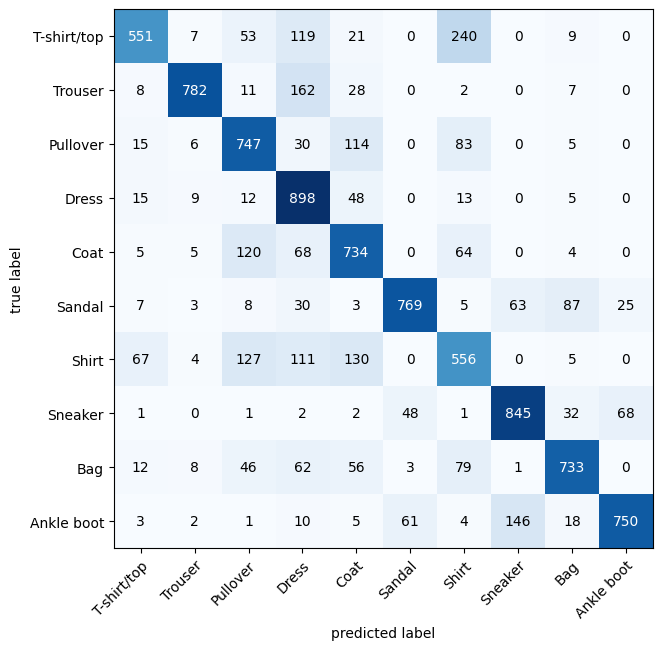

In [217]:
fig,ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.cpu().numpy(),
    class_names=class_names,
    figsize=(10,7)
)

In [218]:
from pathlib import Path

model_path = Path("models")
model_path.mkdir(parents=True,exist_ok=True)

model_name = "model1_cnn.pth"
model_save_path = model_path/model_name
print(f"Saving mode to : {model_save_path}")
torch.save(obj=model1.state_dict(),f=model_save_path)

Saving mode to : models\model1_cnn.pth


In [219]:
loaded_model1 = FashionMnist(input_shape=1,hidden_units=10,output_shape=len(class_names))
loaded_model1.load_state_dict(torch.load(model_save_path))

<All keys matched successfully>